In [1]:
#Dependencies
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import cv2
 

2022-09-11 22:56:18.252236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 22:56:18.252273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
nepoch=15
batch_size=20
tsize=(150,150)

In [3]:
original_dataset_dir = '/run/media/kk/BaKa/Celeb-DF-v2_2/'
base_dir = '/run/media/kk/BaKa/Celeb-DF-v2_2/datasheet/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_fake_dir = os.path.join(train_dir, 'fake')
train_real_dir = os.path.join(train_dir, 'real')
test_fake_dir = os.path.join(test_dir, 'fake')
test_real_dir = os.path.join(test_dir, 'real')

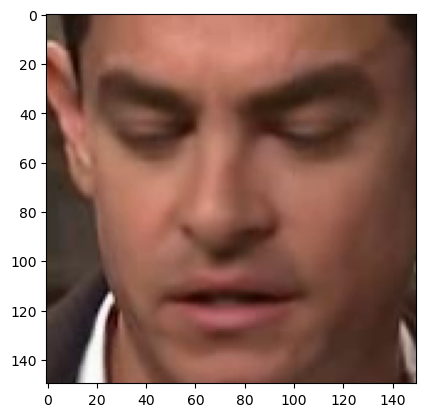

In [4]:
fnames = [os.path.join(train_fake_dir, fname) for fname in os.listdir(train_fake_dir)]
img_path = fnames[30]
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
imgplot = plt.imshow(img)
plt.show()


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=tsize,color_mode='rgb',
                                                    subset= 'training',batch_size=batch_size,class_mode='binary')

Found 3707 images belonging to 2 classes.


In [7]:
val_generator = train_datagen.flow_from_directory(train_dir,target_size=tsize,color_mode='rgb',
                                                  subset= 'validation',batch_size=batch_size,class_mode='binary')

Found 926 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(test_dir,target_size=tsize,color_mode='rgb',batch_size=batch_size,
                                                  class_mode='binary',shuffle=False)

Found 2797 images belonging to 2 classes.


In [9]:
#for data_batch, labels_batch in train_generator:
#    print('data batch shape:', data_batch.shape)
#    print('labels batch shape:', labels_batch.shape)
#    break

In [10]:
########################################################

In [11]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

2022-09-11 22:56:51.289579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kk/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-09-11 22:56:51.289616: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-11 22:56:51.289642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (k-vostro143468): /proc/driver/nvidia/version does not exist
2022-09-11 22:56:51.289952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def extract_features(generator, sample_count):
    i = 0
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_generator, 3707)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 666ms/step


In [14]:
validation_features, validation_labels = extract_features(val_generator, 926)

1/1 [==============================] - 1s 950ms/step


In [15]:
test_features, test_labels = extract_features(test_generator, 2797)

1/1 [==============================] - 2s 2s/step


In [16]:
train_features = np.reshape(train_features, (3707, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (926, 4 * 4 * 512))
test_features = np.reshape(test_features, (2797, 4 * 4 * 512))

In [29]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=100,
batch_size=20,
validation_data=(validation_features, validation_labels))

Epoch 1/100


/home/kk/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


186/186 [==============================] - 5s 25ms/step - loss: 0.4020 - acc: 0.8287 - val_loss: 0.2727 - val_acc: 0.8855
Epoch 2/100
186/186 [==============================] - 5s 27ms/step - loss: 0.2876 - acc: 0.8840 - val_loss: 0.2165 - val_acc: 0.9212
Epoch 3/100
186/186 [==============================] - 5s 28ms/step - loss: 0.2387 - acc: 0.9129 - val_loss: 0.1893 - val_acc: 0.9417
Epoch 4/100
186/186 [==============================] - 5s 27ms/step - loss: 0.2117 - acc: 0.9218 - val_loss: 0.1713 - val_acc: 0.9374
Epoch 5/100
186/186 [==============================] - 5s 24ms/step - loss: 0.1898 - acc: 0.9331 - val_loss: 0.1534 - val_acc: 0.9622
Epoch 6/100
186/186 [==============================] - 5s 25ms/step - loss: 0.1739 - acc: 0.9428 - val_loss: 0.1427 - val_acc: 0.9633
Epoch 7/100
186/186 [==============================] - 5s 28ms/step - loss: 0.1573 - acc: 0.9469 - val_loss: 0.1303 - val_acc: 0.9654
Epoch 8/100
186/186 [==============================] - 5s 25ms/step - loss

Epoch 62/100
186/186 [==============================] - 5s 24ms/step - loss: 0.0169 - acc: 0.9954 - val_loss: 0.0535 - val_acc: 0.9860
Epoch 63/100
186/186 [==============================] - 4s 24ms/step - loss: 0.0161 - acc: 0.9954 - val_loss: 0.0526 - val_acc: 0.9849
Epoch 64/100
186/186 [==============================] - 5s 24ms/step - loss: 0.0170 - acc: 0.9960 - val_loss: 0.0522 - val_acc: 0.9860
Epoch 65/100
186/186 [==============================] - 5s 24ms/step - loss: 0.0159 - acc: 0.9960 - val_loss: 0.0549 - val_acc: 0.9860
Epoch 66/100
186/186 [==============================] - 4s 24ms/step - loss: 0.0147 - acc: 0.9965 - val_loss: 0.0542 - val_acc: 0.9860
Epoch 67/100
186/186 [==============================] - 4s 24ms/step - loss: 0.0141 - acc: 0.9970 - val_loss: 0.0523 - val_acc: 0.9860
Epoch 68/100
186/186 [==============================] - 4s 24ms/step - loss: 0.0159 - acc: 0.9970 - val_loss: 0.0528 - val_acc: 0.9892
Epoch 69/100
186/186 [==============================] -

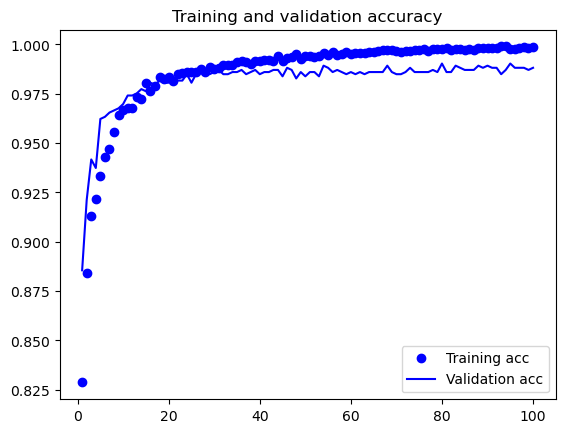

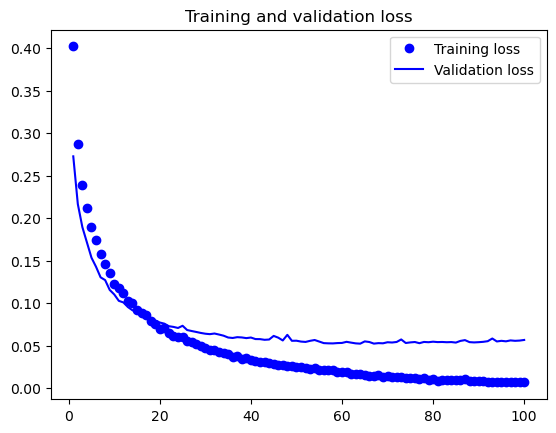

In [31]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
model.evaluate(test_features,test_labels)

88/88 [==============================] - 0s 4ms/step - loss: 0.8925 - acc: 0.8706


[0.8924757242202759, 0.8705756068229675]

In [33]:
model.predict(test_features)

88/88 [==============================] - 0s 4ms/step


array([[6.3306477e-04],
       [5.6147464e-03],
       [1.6554728e-03],
       ...,
       [9.9986571e-01],
       [9.9631423e-01],
       [9.9508542e-01]], dtype=float32)